In [9]:
from qiskit import *

In [10]:
# create a basic circuit to put values of q0, q1, and q3 to c0, c1, c2
nqubits = 3
circuit = QuantumCircuit(nqubits, nqubits)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1 ,2)
circuit.measure([0,1,2], [0,1,2])


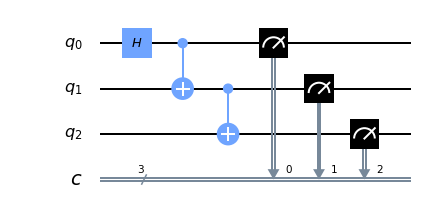

In [11]:
%matplotlib inline
circuit.draw(output='mpl')

In [12]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend = simulator, shots=1024).result()
from qiskit.visualization import plot_histogram

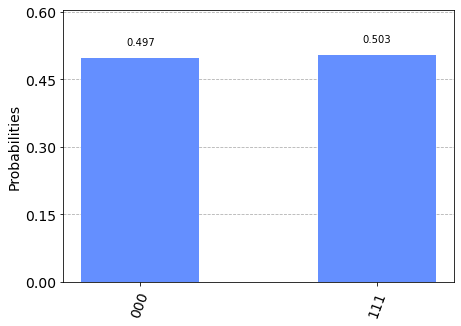

In [13]:
plot_histogram(sim_result.get_counts(circuit))

In [14]:
# run program on real quantum computer
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmqx2')

In [15]:
job = execute(circuit, backend = device, shots = 1024)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)
# test program without noise mitegation with visible errors in output

5f20399c49d926001383c8ae
Job Status: job has successfully run


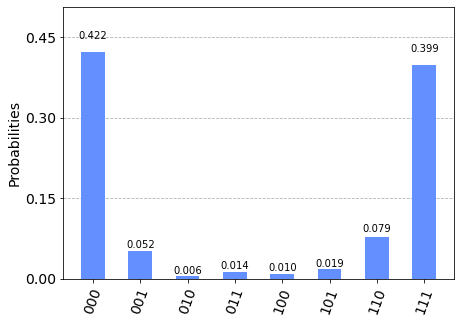

In [16]:
device_result = job.result(0)
plot_histogram(device_result.get_counts(circuit))

In [17]:
# building a mitigation circuit

from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [18]:
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')

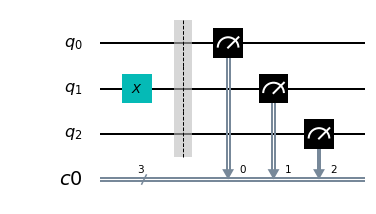

In [19]:
cal_circuits[2].draw(output='mpl')

In [20]:
len(cal_circuits)

8

In [22]:
cal_job = execute(cal_circuits, backend = device, shots = 1024, optimization_level = 0)
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

5f203a975498260013fb4395
Job Status: job has successfully run


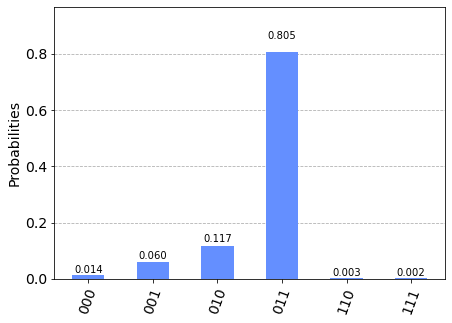

In [23]:
plot_histogram(cal_results.get_counts(cal_circuits[3]))

In [24]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

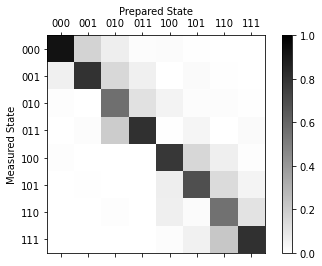

In [25]:
meas_fitter.plot_calibration()

In [26]:
# creating a mitigation filter using the mitigation circuit datat
meas_filter = meas_fitter.filter

In [27]:
mitigated_result = meas_filter.apply(device_result)

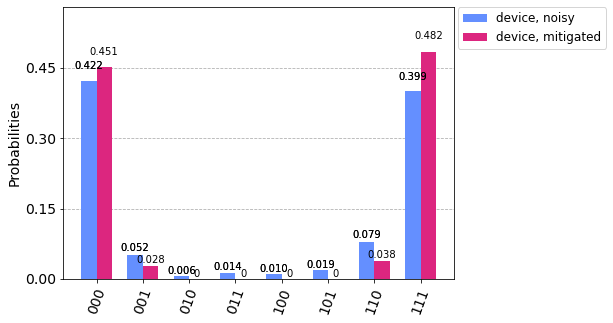

In [32]:
# blue is none filtered result and red is mitigated filtered result showing much more efficent data
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

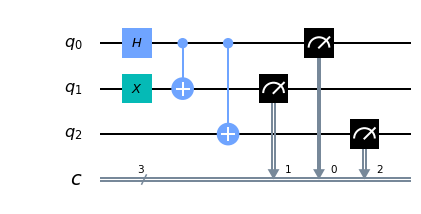

In [33]:
#build a second program with 3 qubits to test again

circuit2 = QuantumCircuit(3, 3)
circuit2.x(1)
circuit2.h(0)
circuit2.cx(0, 1)
circuit2.cx(0, 2)
circuit2.measure([0,1,2], [0,1,2])
circuit2.draw(output='mpl')

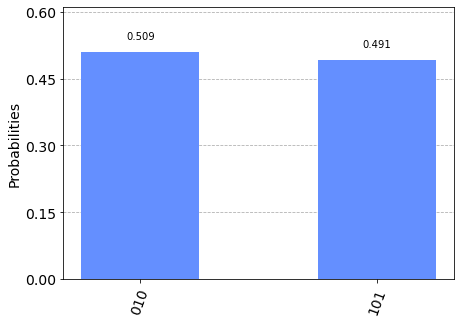

In [38]:
# simulate circuit (no errors)
plot_histogram(
    execute(circuit2, backend = simulator, shots = 1024).result().get_counts(circuit2)
)

In [45]:
# run circuit on real hardware
device_counts_2 = execute(circuit2, backend=device, shots=1024).result().get_counts(circuit2)

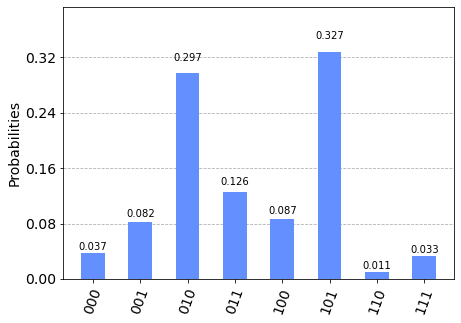

In [46]:
ot_histogram(device_counts_2)pl